# Natural Language Processing & Machine Learning

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf

In [2]:
%matplotlib notebook

In [3]:
# Get the dataset from here: https://www.kaggle.com/uciml/sms-spam-collection-dataset

df = pd.read_csv("data/spam.csv", names=['status', 'message', 'crap1', 'crap2', 'crap3'], 
                 header=None, skiprows=[0], encoding='latin-1')

In [4]:
df.head()

,status,message,crap1,crap2,crap3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Let's see how the csv looks like on the others fields
df_tmp = df[df['crap1'].notnull() | df['crap2'].notnull() | df['crap3'].notnull()]
df_tmp

,status,message,crap1,crap2,crap3
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


In [6]:
# Let's see if we can discard those rows:
df.size, df_tmp.size, df_tmp.size/df.size

(27860, 250, 0.008973438621679828)

In [7]:
# Let's remove the rows of df_tmp from df
df = df.drop(df_tmp.index)
df.size

27610

In [8]:
# Just leave status and message!
df = df.drop(columns=['crap1', 'crap2', 'crap3'])
df.head()

,status,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# If you just installed nltk don't forget this:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
    

[nltk_data] Downloading package punkt to /Users/rhf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rhf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Let's do some NLP to the message"

stemmer = SnowballStemmer('english')

def process_text(text):
    '''
    Thanks:
    https://stackoverflow.com/questions/45670532/stemming-words-with-nltk-python
    '''
    # Remove non-letters, but don't remove whitespaces just yet. You can also simplify your regex a bit.
    letters_only = re.sub("[^\w\s]", " ", text) 

    # Convert to lower case, split into individual words: I recommend using word_tokenize again, here.
    words = word_tokenize(letters_only.lower())                  

    # Remove stop words.
    stops = set(stopwords.words("english")) 
    meaningful_words = [w for w in words if not w in stops]
    
    # Stem words. Here is another issue. Stem meaningful_words, not words.
    return ' '.join([stemmer.stem(w) for w in meaningful_words])

In [11]:
# An example of what the function above does:
print("Before:", df['message'][0])
print("After :", process_text(df['message'][0]))

Before: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
After : go jurong point crazi avail bugi n great world la e buffet cine got amor wat


In [12]:
# spam/ham as a number!
df['status_int'] = df['status'].apply(lambda x: 1.0 if x == "ham" else 0.0)
df['message_processed'] = df['message'].apply(process_text)
df.head(10)

,status,message,status_int,message_processed
0,ham,"Go until jurong point, crazy.. Available only ...",1.0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,1.0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.0,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,1.0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",1.0,nah think goe usf live around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,0.0,freemsg hey darl 3 week word back like fun sti...
6,ham,Even my brother is not like to speak with me. ...,1.0,even brother like speak treat like aid patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,1.0,per request mell mell oru minnaminungint nurun...
8,spam,WINNER!! As a valued network customer you have...,0.0,winner valu network custom select receivea å 9...
9,spam,Had your mobile 11 months or more? U R entitle...,0.0,mobil 11 month u r entitl updat latest colour ...


In [13]:
# First let's understand what are the SKLearn Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
# Let's select a few messages
messages = df['message'][[0,1,3]].tolist()
# transform text in messages into ocurrences of feature_names. See below
messages_cv = cv.fit_transform(messages)

print(20*'-', "messages raw", 20*'-')
pprint(messages)
print(20*'-', "messages as count vectoriser: ocurrences in features", 20*'-')
pprint(messages_cv.toarray())
print(20*'-', "feature names", 20*'-')
pprint(cv.get_feature_names())
print(20*'-', "Inverse transform for the first message", 20*'-')
cv.inverse_transform(messages_cv[0])

-------------------- messages raw --------------------
['Go until jurong point, crazy.. Available only in bugis n great world la e '
 'buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 'U dun say so early hor... U c already then say...']
-------------------- messages as count vectoriser: ocurrences in features --------------------
array([[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 0, 0, 0, 0, 0]], dtype=int64)
-------------------- feature names --------------------
['already',
 'amore',
 'available',
 'buffet',
 'bugis',
 'cine',
 'crazy',
 'dun',
 'early',
 'go',
 'got',
 'great',
 'hor',
 'in',
 'joking',
 'jurong',
 'la',
 'lar',
 'ok',
 'oni',
 'only',
 'point',
 'say',
 'so',
 'then',
 'there',
 'until',
 '

[array(['wat', 'amore', 'got', 'there', 'cine', 'buffet', 'la', 'world',
        'great', 'bugis', 'in', 'only', 'available', 'crazy', 'point',
        'jurong', 'until', 'go'], dtype='<U9')]

TFIDF (term frequency - inverse document frequency) is a statistical method to tell how important a word is to a particular document by increasing the numerical value for an occurrence in the specific document but decreasing relative to number of occurrences in the entire corpus.


In [14]:
vectorizer = TfidfVectorizer("english")
messages_processed = df['message_processed'].tolist()
features = vectorizer.fit_transform(messages_processed)

# Let's split the dataset into train and test
features_train, features_test, labels_train, labels_test = train_test_split(
    features, df['status_int'], test_size=0.25, random_state=123
)

# Machine learning

##  C-Support Vector Classification

<IPython.core.display.Javascript object>


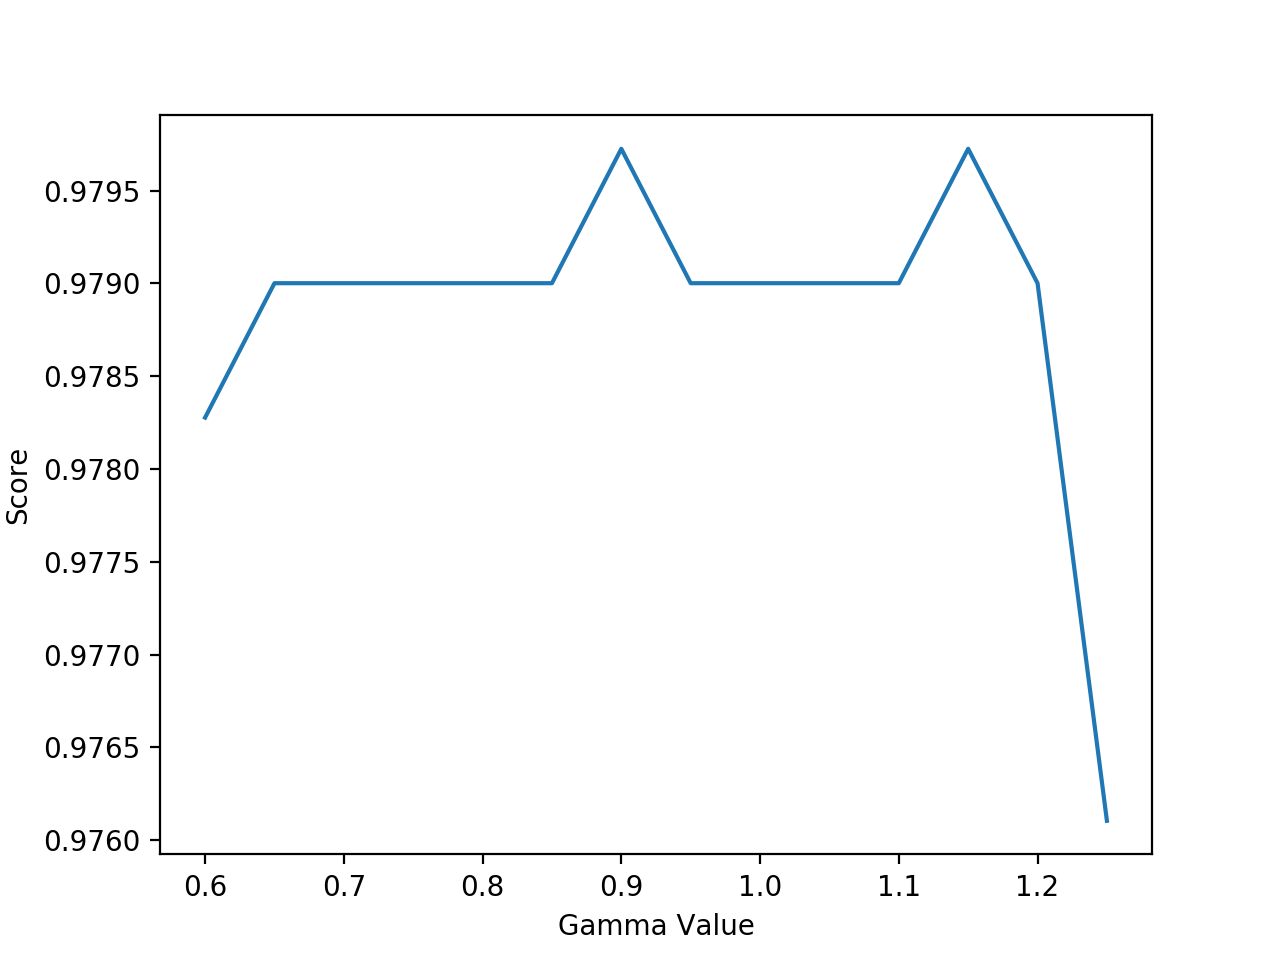

**** The best gamma value is 0.9 with a score of 0.98.


In [15]:
gammas = np.arange(0.6,1.3,0.05)
scores = []

for gamma in gammas:
    svc = SVC(kernel='sigmoid', gamma=gamma)
    svc.fit(features_train, labels_train)
    prediction = svc.predict(features_test)
    score = accuracy_score(labels_test, prediction)
    scores.append(score)

plt.figure()
plt.plot(gammas,scores)
plt.xlabel("Gamma Value")
plt.ylabel("Score")

print("**** The best gamma value is {:.3} with a score of {:.3}.".format(
    gammas[np.argmax(scores)], np.max(scores)))

# Multinomial Naive Bayes Model

<IPython.core.display.Javascript object>


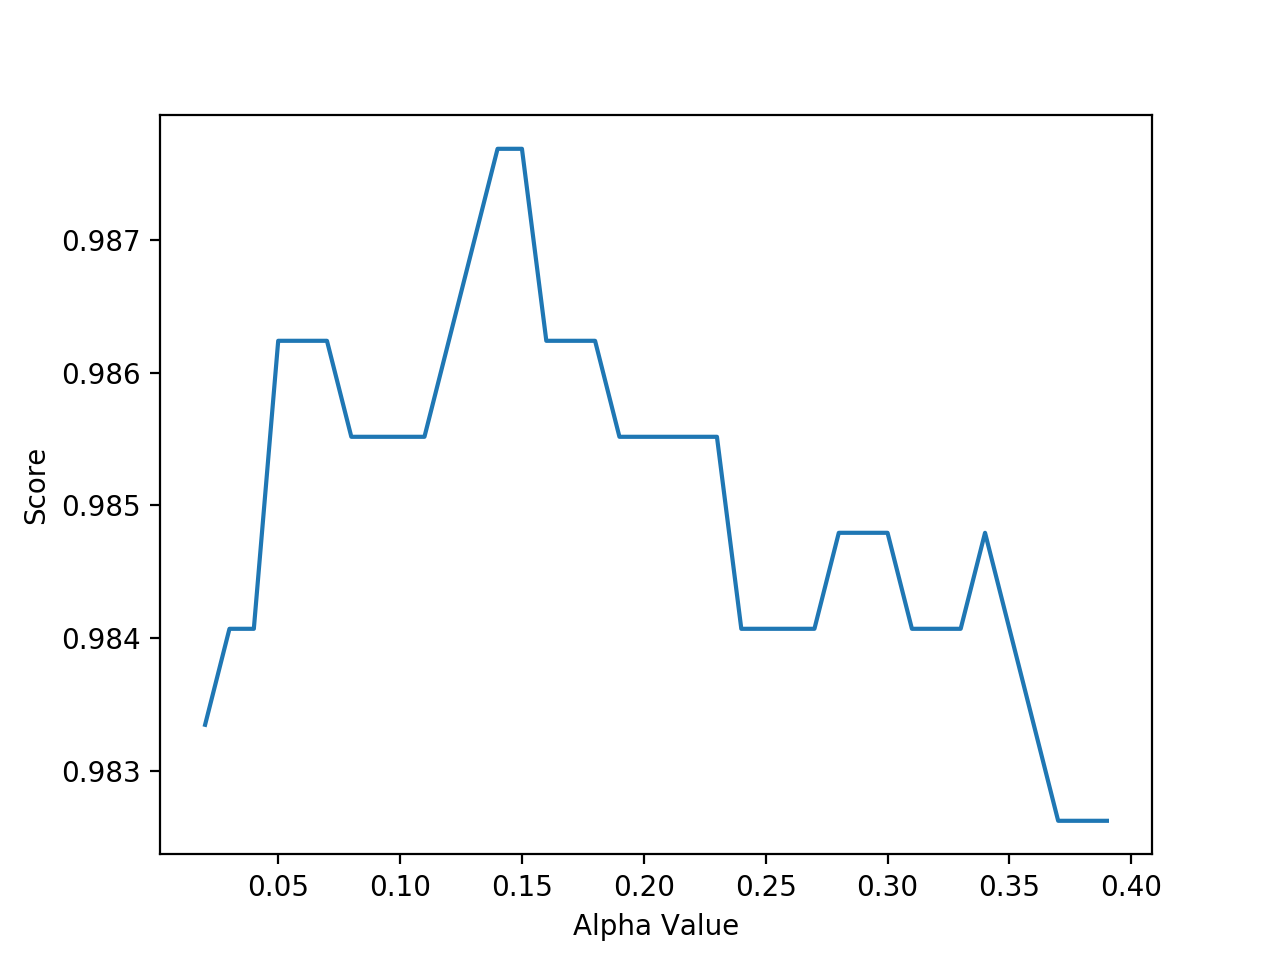

**** The best alpha value is 0.14 with a score of 0.988.


In [16]:
alphas = np.arange(0.02,0.4,0.01)
scores = []

for alpha in alphas:
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(features_train, labels_train)
    prediction = mnb.predict(features_test)
    score = accuracy_score(labels_test, prediction)
    scores.append(score)

plt.figure()
plt.plot(alphas, scores)
plt.xlabel("Alpha Value")
plt.ylabel("Score")

print("**** The best alpha value is {:.3} with a score of {:.3}.".format(
    alphas[np.argmax(scores)], np.max(scores)))

## Neural Network (Keras)

In [17]:
features_train.shape, features_test.shape, features_train.shape[1]

((4141, 7135), (1381, 7135), 7135)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

epochs=10
batch_size=10

# Model
model = Sequential()
model.add(Dense(12, input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(int(features_train.shape[1]/2), activation='relu'))
model.add(Dense(int(features_train.shape[1]/4), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(features_train, labels_train, epochs=epochs, batch_size=batch_size)

predictions = model.predict(features_test)
# Because we use a sigmoid at the end and it gives a probability between 0 and 1
# Round it to the closest integer
rounded = [round(x[0]) for x in predictions]

score = accuracy_score(labels_test, rounded)
print("\n***** Final score of {:.3}.".format(score))

Using TensorFlow backend.


Epoch 1/10
4141/4141 [==============================] - 29s 7ms/step - loss: 0.1688 - acc: 0.9433
Epoch 2/10
4141/4141 [==============================] - 29s 7ms/step - loss: 0.0182 - acc: 0.9959
Epoch 3/10
4141/4141 [==============================] - 28s 7ms/step - loss: 0.0072 - acc: 0.9978
Epoch 4/10
4141/4141 [==============================] - 28s 7ms/step - loss: 0.0019 - acc: 0.9998
Epoch 5/10
4141/4141 [==============================] - 28s 7ms/step - loss: 7.9349e-05 - acc: 1.0000
Epoch 6/10
4141/4141 [==============================] - 28s 7ms/step - loss: 1.2321e-05 - acc: 1.0000
Epoch 7/10
4141/4141 [==============================] - 30s 7ms/step - loss: 6.5070e-06 - acc: 1.0000
Epoch 8/10
4141/4141 [==============================] - 29s 7ms/step - loss: 3.4355e-06 - acc: 1.0000
Epoch 9/10
4141/4141 [==============================] - 27s 6ms/step - loss: 1.7566e-06 - acc: 1.0000
Epoch 10/10
4141/4141 [==============================] - 28s 7ms/step - loss: 1.0465e-06 - acc: 1.

In [21]:
# list all data in history
history.history.keys()

dict_keys(['loss', 'acc'])

<IPython.core.display.Javascript object>


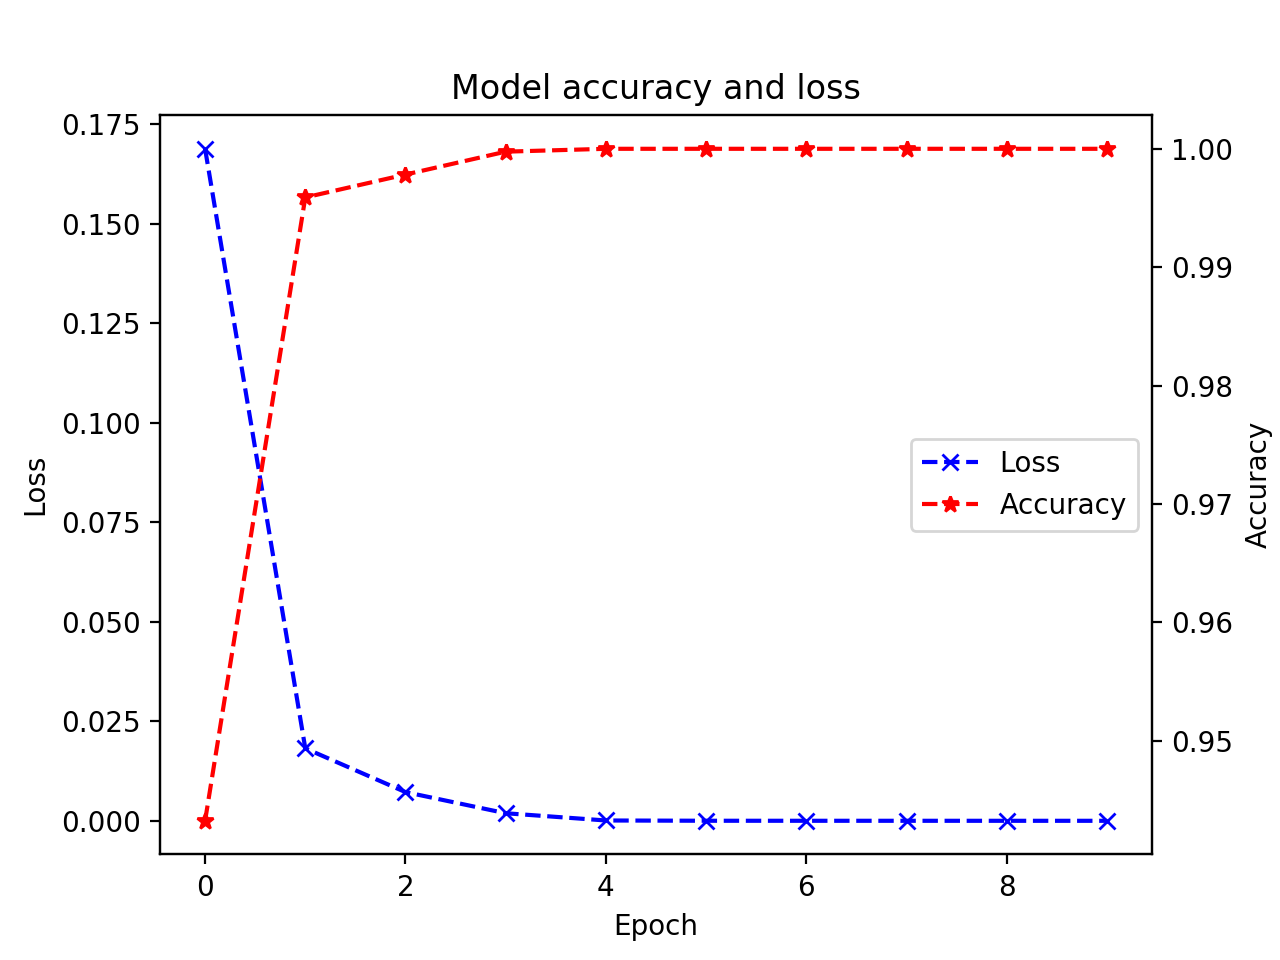

In [40]:
fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'], 'bx--', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax2 = ax1.twinx()
ax2.plot(history.history['acc'], 'r*--', label='Accuracy')
ax2.set_ylabel('Accuracy')
plt.title('Model accuracy and loss')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='center right')
